In [25]:
import os
from pyspark.sql import SparkSession
from pyspark.sql.functions import sum as Fsum, col, avg, count, mode, udf, round as _round, lit
from pyspark.sql import functions as F
from pyspark.sql.window import Window
from pyspark.sql.types import DoubleType
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
from shapely.geometry import Point

In [26]:
# Initialize Spark session
spark = SparkSession.builder.appName("Caen Accessibility Analysis").getOrCreate()

In [27]:
# Fix for Py4J pandas handling issue
spark.conf.set("spark.sql.execution.pandas.convertStructToMap", "false")

In [28]:
# Read CSV file into a Spark DataFrame
df = spark.read.csv(
    'C:/Users/kbons/accessibility/Caen/Analytics/caen_all_merge.csv', 
    header=True, 
    inferSchema=True
)

In [29]:
typo_corrections = {
    "services_for_indivduals": "services_for_individuals",
    }

df = df.replace(typo_corrections, subset=["domain"])

In [30]:
df.persist()

DataFrame[fid: int, isochrone_: string, mode: string, domain: string, time: int, LATITUDE: double, LONGITUDE: double, point_coun: int, Id: int, layer: string, path: string]

In [31]:
# Convert time from seconds to minutes for better readability
df = df.withColumn("time_min", col("time") / 60)

In [32]:
# Aggregate by summing point_coun, grouping by key columns
df_agg = df.groupBy("isochrone_", "mode", "domain", "time_min").agg(Fsum("point_coun").alias("point_count"))\
      .orderBy("isochrone_", "mode", "domain", "time_min") \
      

df_agg.show(truncate=False)

+------------------------------+-------+------------------------+--------+-----------+
|isochrone_                    |mode   |domain                  |time_min|point_count|
+------------------------------+-------+------------------------+--------+-----------+
|CRS3035RES200mN2942800E3571200|Bicycle|education               |15.0    |6          |
|CRS3035RES200mN2942800E3571200|Bicycle|education               |30.0    |2832       |
|CRS3035RES200mN2942800E3571200|Bicycle|education               |45.0    |27720      |
|CRS3035RES200mN2942800E3571200|Bicycle|education               |60.0    |84005      |
|CRS3035RES200mN2942800E3571200|Bicycle|education               |75.0    |95586      |
|CRS3035RES200mN2942800E3571200|Bicycle|education               |90.0    |106533     |
|CRS3035RES200mN2942800E3571200|Bicycle|health_and_social_action|15.0    |704        |
|CRS3035RES200mN2942800E3571200|Bicycle|health_and_social_action|30.0    |383311     |
|CRS3035RES200mN2942800E3571200|Bicycle|hea

In [33]:
df_agg.persist()

DataFrame[isochrone_: string, mode: string, domain: string, time_min: double, point_count: bigint]

In [34]:
# Calculate the total point count
total_point_count = df_agg.select(Fsum("point_count")).collect()[0][0]

# Calculate the percentage for each row
df_agg = df_agg.withColumn("percentage_point_count", (col("point_count") / total_point_count) * 100)

# Show the result
df_agg.select("isochrone_", "domain", "time_min", "point_count", "percentage_point_count").show(10)

+--------------------+--------------------+--------+-----------+----------------------+
|          isochrone_|              domain|time_min|point_count|percentage_point_count|
+--------------------+--------------------+--------+-----------+----------------------+
|CRS3035RES200mN29...|           education|    15.0|          6|  1.335394844272244E-9|
|CRS3035RES200mN29...|           education|    30.0|       2832|  6.303063664964992E-7|
|CRS3035RES200mN29...|           education|    45.0|      27720|  6.169524180537768E-6|
|CRS3035RES200mN29...|           education|    60.0|      84005|  1.869664064884831E-5|
|CRS3035RES200mN29...|           education|    75.0|      95586|  2.127417526410112E-5|
|CRS3035RES200mN29...|           education|    90.0|     106533|  2.371060315747583E-5|
|CRS3035RES200mN29...|health_and_social...|    15.0|        704|  1.566863283946099...|
|CRS3035RES200mN29...|health_and_social...|    30.0|     383311|  8.531192219213969E-5|
|CRS3035RES200mN29...|health_and

In [35]:
# Define the window specification
window_spec = Window.partitionBy("isochrone_", "mode", "domain").orderBy("time_min")

# Compute lagged percentage_count to get previous time's percentage
df_agg = df_agg.withColumn("prev_percentage", F.lag("percentage_point_count").over(window_spec))

# Compute the percentage difference
df_agg = df_agg.withColumn(
    "percentage_diff",
    F.when(col("prev_percentage").isNull(), col("percentage_point_count"))  # First interval keeps its value
    .otherwise(col("percentage_point_count") - col("prev_percentage"))
)

# Show result
df_agg.select("isochrone_", "mode", "domain", "time_min", "percentage_point_count", "percentage_diff").show(truncate=False)




+------------------------------+-------+------------------------+--------+----------------------+---------------------+
|isochrone_                    |mode   |domain                  |time_min|percentage_point_count|percentage_diff      |
+------------------------------+-------+------------------------+--------+----------------------+---------------------+
|CRS3035RES200mN2942800E3571200|Bicycle|health_and_social_action|15.0    |1.5668632839460997E-7 |1.5668632839460997E-7|
|CRS3035RES200mN2942800E3571200|Bicycle|health_and_social_action|30.0    |8.531192219213969E-5  |8.515523586374509E-5 |
|CRS3035RES200mN2942800E3571200|Bicycle|health_and_social_action|45.0    |5.721659457665742E-4  |4.8685402357443456E-4|
|CRS3035RES200mN2942800E3571200|Bicycle|health_and_social_action|60.0    |0.0012600939320959986 |6.879279863294243E-4 |
|CRS3035RES200mN2942800E3571200|Bicycle|health_and_social_action|75.0    |0.001374479180574404  |1.1438524847840544E-4|
|CRS3035RES200mN2942800E3571200|Bicycle|

**We keep decay function between 0 and 2** 

This adjustment ensures that the decay factors remain realistic and within the desired range, while still reflecting the relative importance of the services and how accessibility decreases as time or distance increases.


**Explanation:**

Education (b = 1.5): Education services have a moderate importance and are often worth traveling for, but the decay is not as sharp as for less essential services. A decay factor of 1.5 reflects this balance.

Health and Social Action (b = 1.8): These services are highly critical, but as they can be somewhat concentrated in specific locations, a higher decay factor of 1.8 is used, reflecting a faster decrease in accessibility as time increases.

Services for Individuals (b = 1.5): Similar to education, these services are important, but not as critical as health, so we use a moderate decay factor of 1.5.

Shops (b = 1.0): Shops are generally more ubiquitous, and people are willing to travel moderate distances to access them. The decay factor is set lower (1.0) to reflect that people can travel longer distances to shop.

Sports, Leisure, and Recreation (b = 1.8): These services are less essential, and people may travel longer distances for leisure activities, but they still lose accessibility relatively quickly. Therefore, a decay factor of 1.8 is used.

Tourism (b = 1.9): Similar to sports and leisure, tourism services tend to have lower necessity, but they may see a sharper decrease in accessibility as time increases, so a higher decay factor of 1.9 is used.

Transport and Travel (b = 1.0): Transport and travel services are essential for long-distance movement, but accessibility doesn't decline as sharply over time or distance as other services. Hence, the decay factor is kept at 1.0.

In [36]:
# Define the decay factors for each domain
decay_factors = {
    "education": 1.5,
    "health_and_social_action": 1.8,
    "services_for_individuals": 1.5,
    "shops": 1.0,
    "sports_leisure_and_recreation": 1.8,
    "tourism": 1.9,
    "transport_and_travel": 1.0
}

# Create a column for the decay factor (b) based on the 'domain' column
df_agg = df_agg.withColumn(
    "decay_factor", 
    F.when(F.col("domain") == "education", F.lit(decay_factors["education"]))
    .when(F.col("domain") == "health_and_social_action", F.lit(decay_factors["health_and_social_action"]))
    .when(F.col("domain") == "services_for_individuals", F.lit(decay_factors["services_for_individuals"]))
    .when(F.col("domain") == "shops", F.lit(decay_factors["shops"]))
    .when(F.col("domain") == "sports_leisure_and_recreation", F.lit(decay_factors["sports_leisure_and_recreation"]))
    .when(F.col("domain") == "tourism", F.lit(decay_factors["tourism"]))
    .when(F.col("domain") == "transport_and_travel", F.lit(decay_factors["transport_and_travel"]))
    .otherwise(F.lit(1.0))  # Default decay factor if domain doesn't match
)

# Show the DataFrame to verify the new column
df_agg.select("isochrone_", "domain", "decay_factor").show(5)


+--------------------+---------+------------+
|          isochrone_|   domain|decay_factor|
+--------------------+---------+------------+
|CRS3035RES200mN29...|education|         1.5|
|CRS3035RES200mN29...|education|         1.5|
|CRS3035RES200mN29...|education|         1.5|
|CRS3035RES200mN29...|education|         1.5|
|CRS3035RES200mN29...|education|         1.5|
+--------------------+---------+------------+
only showing top 5 rows



In [37]:
# Display schema to verify data types
df_agg.printSchema()

root
 |-- isochrone_: string (nullable = true)
 |-- mode: string (nullable = true)
 |-- domain: string (nullable = true)
 |-- time_min: double (nullable = true)
 |-- point_count: long (nullable = true)
 |-- percentage_point_count: double (nullable = true)
 |-- prev_percentage: double (nullable = true)
 |-- percentage_diff: double (nullable = true)
 |-- decay_factor: double (nullable = false)



In [41]:
# Compute the accessibility using the decay factor
df_agg = df_agg.withColumn(
    "accessibility", 
    (col("percentage_diff") / (col("time_min") ** col("decay_factor")))
)

In [42]:
# Extract characters from the 15th to 22nd position 
df_agg = df_agg.withColumn("y", F.substring("isochrone_", 16, 7))  

# Extract characters from the 23rd to 30th position
df_agg = df_agg.withColumn("x", F.substring("isochrone_", 24, 7))


In [43]:
# Show the resulting DataFrame with the accessibility column
df_agg.select("isochrone_", "mode", "domain", "time_min", "accessibility", "x", "y").show(truncate = False)

+------------------------------+-------+------------------------+--------+----------------------+-------+-------+
|isochrone_                    |mode   |domain                  |time_min|accessibility         |x      |y      |
+------------------------------+-------+------------------------+--------+----------------------+-------+-------+
|CRS3035RES200mN2942800E3571200|Bicycle|health_and_social_action|15.0    |1.1969247230284821E-9 |3571200|2942800|
|CRS3035RES200mN2942800E3571200|Bicycle|health_and_social_action|30.0    |1.8680697922107082E-7 |3571200|2942800|
|CRS3035RES200mN2942800E3571200|Bicycle|health_and_social_action|45.0    |5.147735675362238E-7  |3571200|2942800|
|CRS3035RES200mN2942800E3571200|Bicycle|health_and_social_action|60.0    |4.3338185795330953E-7 |3571200|2942800|
|CRS3035RES200mN2942800E3571200|Bicycle|health_and_social_action|75.0    |4.8223613049135615E-8 |3571200|2942800|
|CRS3035RES200mN2942800E3571200|Bicycle|health_and_social_action|90.0    |4.766323289678

In [44]:
### Exploratory Data Analysis (EDA)
print("Total records in dataset:", df_agg.count())

Total records in dataset: 217502


In [45]:
# number of records per transport mode
mode_counts = df_agg.groupBy("mode").count().collect()
mode_counts_pd = pd.DataFrame(mode_counts, columns=['mode','count'])

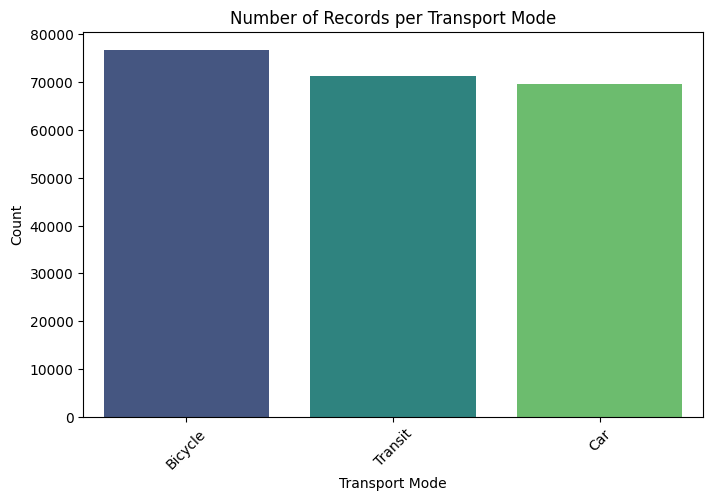

In [46]:
mode_counts_pd = mode_counts_pd.sort_values(by="count", ascending=False)
plt.figure(figsize=(8, 5))
sns.barplot(data=mode_counts_pd, x="mode", y="count", hue = 'mode', palette="viridis", legend = False)
plt.title("Number of Records per Transport Mode")
plt.xlabel("Transport Mode")
plt.ylabel("Count")
plt.xticks(rotation=45)
#plt.savefig("transport_mode_distribution.png")
plt.show()

In [47]:
# Average accessibility of each facility type
df_agg.groupBy("domain").agg(avg("accessibility").alias("avg_accessibility")).show()

+--------------------+--------------------+
|              domain|   avg_accessibility|
+--------------------+--------------------+
|           education|1.976681658103517...|
|services_for_indi...|9.385407655046988E-7|
|               shops| 4.22348727955604E-6|
|             tourism|1.077417260433381...|
|sports_leisure_an...|4.304565236792262E-8|
|health_and_social...|4.230048862559863...|
|transport_and_travel|1.256175308440951...|
+--------------------+--------------------+



In [48]:
facility_access = df_agg.groupBy("domain").agg(avg("accessibility").alias("avg_accessibility")).collect()
facility_access_pd = pd.DataFrame(facility_access, columns=['domain', 'avg_accessibility'])

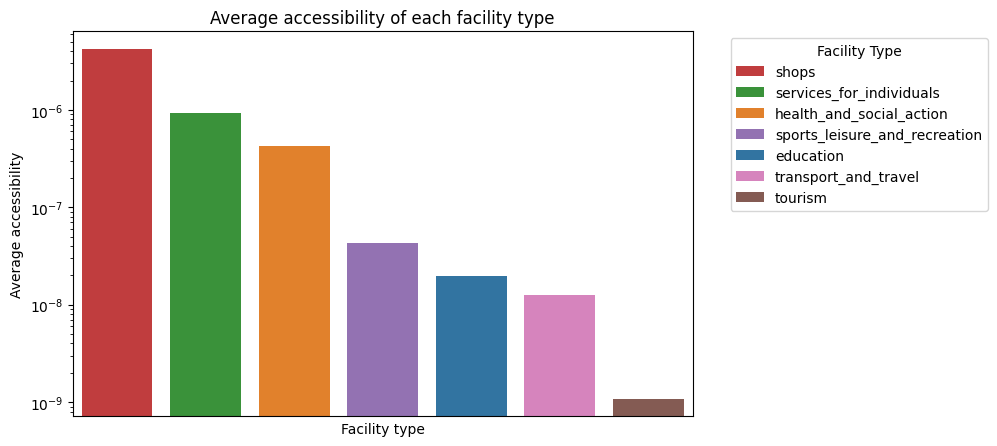

In [49]:
facility_access_pd = facility_access_pd.sort_values(by="avg_accessibility", ascending=False)
plt.figure(figsize=(8, 5))


# Define custom colors for each facility type (category in "domain")
custom_palette = {
    "education": "#1f77b4",  # Blue  
    "health_and_social_action": "#ff7f0e",  # Orange 
    "services_for_individuals": "#2ca02c",  # Green
    "shops": "#d62728",  # Red 
    "sports_leisure_and_recreation": "#9467bd",  # Purple 
    "tourism": "#8c564b",  # Brown 
    "transport_and_travel": "#e377c2"  # Pink 
}

sns.barplot(data=facility_access_pd, x="domain", y="avg_accessibility", hue ="domain", palette= custom_palette, legend = True)
plt.yscale("log")  # Change scale to make small values more visible
plt.title("Average accessibility of each facility type")
plt.xlabel("Facility type")
plt.ylabel("Average accessibility")
plt.xticks([])
plt.legend(title="Facility Type", bbox_to_anchor=(1.05, 1), loc='upper left')  # Move legend outside
#plt.savefig("Average accessibility of each facility type.png")
plt.show()

In [50]:
# Accessibility per transport mode and facility type
df_agg.groupBy("mode", "domain").agg(avg("accessibility").alias("avg_facility_count")).show()

+-------+--------------------+--------------------+
|   mode|              domain|  avg_facility_count|
+-------+--------------------+--------------------+
|Bicycle|               shops|3.051808597698422...|
|Transit|             tourism|2.907345762072865...|
|    Car|services_for_indi...|9.385407655046993E-7|
|Transit|transport_and_travel| 3.55549213300747E-9|
|    Car|transport_and_travel|2.546031546365416...|
|    Car|health_and_social...|7.963221440050429E-7|
|    Car|           education|3.901291579169877E-8|
|Bicycle|           education|1.496260393750353...|
|Bicycle|sports_leisure_an...|2.952693384614437...|
|Transit|sports_leisure_an...|8.304056784514426E-9|
|    Car|             tourism|2.234284872546460...|
|Transit|           education|6.183727258627235E-9|
|Transit|health_and_social...|1.381327637440875...|
|    Car|               shops|8.542041457096713E-6|
|Transit|               shops|1.443487741339099...|
|    Car|sports_leisure_an...|9.566200233379151E-8|
|Bicycle|ser

In [51]:
mode_facility_access = df_agg.groupBy("mode", "domain").agg(avg("accessibility").alias("avg_facility_count")).collect()
mode_facility_access_pd = pd.DataFrame(mode_facility_access, columns = ['mode', 'domain', 'avg_facility_count'])

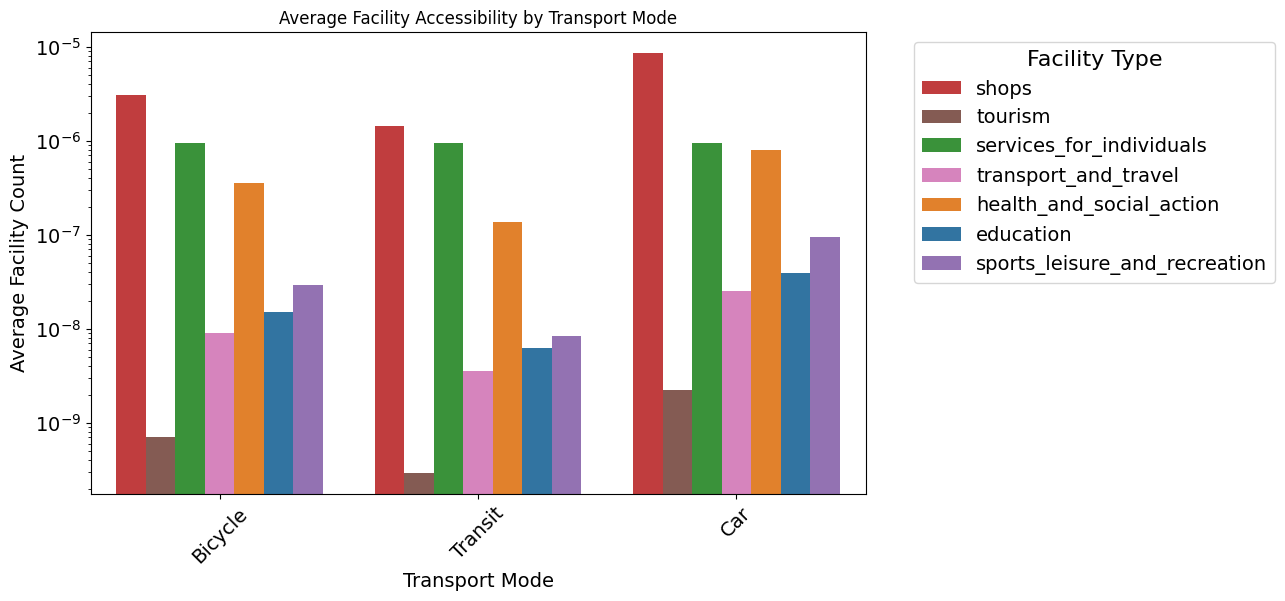

In [52]:
plt.figure(figsize=(10, 6))

# Define custom colors for each facility type (category in "domain")
custom_palette = {
    "education": "#1f77b4",  # Blue  
    "health_and_social_action": "#ff7f0e",  # Orange 
    "services_for_individuals": "#2ca02c",  # Green
    "shops": "#d62728",  # Red 
    "sports_leisure_and_recreation": "#9467bd",  # Purple 
    "tourism": "#8c564b",  # Brown 
    "transport_and_travel": "#e377c2"  # Pink 
}

sns.barplot(data=mode_facility_access_pd, x="mode", y="avg_facility_count", hue="domain", palette=custom_palette)
plt.yscale("log")  # Change scale to make small values more visible
plt.title("Average Facility Accessibility by Transport Mode")
plt.xlabel("Transport Mode", fontsize = 14)
plt.ylabel("Average Facility Count", fontsize = 14)
plt.yticks(fontsize = 14)
plt.xticks(fontsize = 14, rotation=45)
plt.legend(title="Facility Type", title_fontsize = 16, bbox_to_anchor=(1.05, 1), loc="upper left", fontsize = 14)
plt.savefig("facility_accessibility_by_mode.png")
plt.show()

In [53]:
# Identify the transport mode with the highest accessibility overall
df_agg.groupBy("mode").agg(avg("accessibility").alias("avg_accessibility")).orderBy(col("avg_accessibility").desc()).show()

+-------+--------------------+
|   mode|   avg_accessibility|
+-------+--------------------+
|    Car|1.492021352253322E-6|
|Bicycle|6.313035537808153E-7|
|Transit| 3.83159845305591E-7|
+-------+--------------------+



In [54]:
mode_access = df_agg.groupBy("mode").agg(avg("accessibility").alias("avg_accessibility")).orderBy(col("avg_accessibility").desc()).collect()
mode_access_pd = pd.DataFrame(mode_access, columns = ['mode', 'avg_accessibility'])

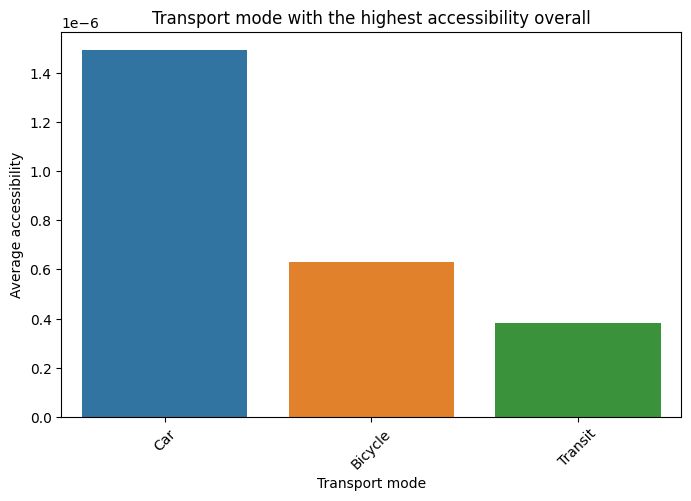

In [56]:
plt.figure(figsize=(8, 5))
sns.barplot(data=mode_access_pd, x="mode", y="avg_accessibility", hue = 'mode', palette="tab10", legend = False)
plt.title("Transport mode with the highest accessibility overall")
plt.xlabel("Transport mode")
plt.ylabel("Average accessibility")
plt.xticks(rotation=45)
#plt.savefig("Transport mode with the highest accessibility overall.png")
plt.show()

In [57]:
# Accessibility to facilities over different time intervals
df_agg.groupBy("time_min").agg(avg("accessibility").alias("avg_facilities_over_time")).orderBy("time_min").show()

+--------+------------------------+
|time_min|avg_facilities_over_time|
+--------+------------------------+
|    15.0|    2.241012349435708...|
|    30.0|    1.723682225099345...|
|    45.0|    1.163234202276722...|
|    60.0|    9.334563814398052E-7|
|    75.0|    5.207477719860028E-7|
|    90.0|    3.645760962867337...|
+--------+------------------------+



In [58]:
time_accessibility = df_agg.groupBy("time_min").agg(avg("accessibility").alias("avg_facilities_over_time")).orderBy("time_min").collect()
time_accessibility_pd = pd.DataFrame(time_accessibility, columns=["time_min", "avg_facilities_over_time"])

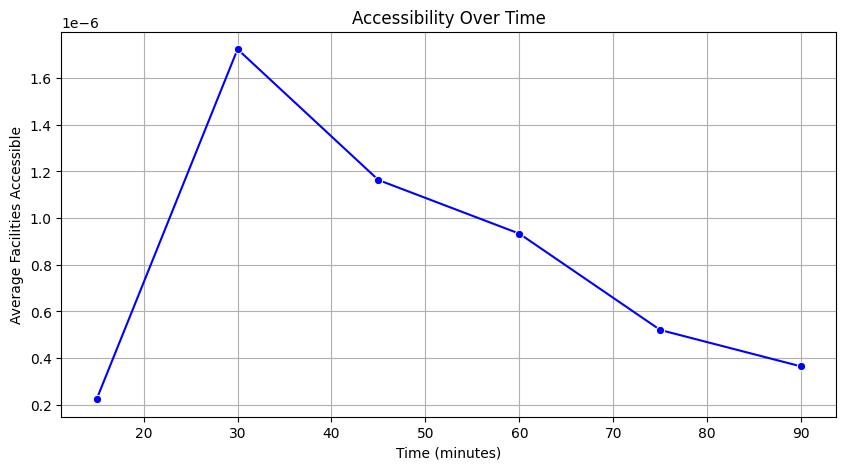

In [60]:
plt.figure(figsize=(10, 5))
sns.lineplot(data=time_accessibility_pd, x="time_min", y="avg_facilities_over_time", marker="o", color="blue")
plt.title("Accessibility Over Time")
plt.xlabel("Time (minutes)")
plt.ylabel("Average Facilities Accessible")
plt.grid()
#plt.savefig("accessibility_over_time.png")
plt.show()

In [61]:
# Compare accessibility between transport modes over time
df_agg.groupBy("mode", "time_min").agg(avg("accessibility").alias("avg_facilities")).show()

+-------+--------+--------------------+
|   mode|time_min|      avg_facilities|
+-------+--------+--------------------+
|    Car|    45.0|1.604796072284505E-6|
|Transit|    30.0| 4.59750886920001E-7|
|Bicycle|    90.0|1.644812419908893E-7|
|    Car|    90.0|8.830591863690271E-7|
|Bicycle|    30.0|1.271208124775173...|
|Transit|    45.0|7.503022681857758E-7|
|Transit|    60.0|6.266773246426749E-7|
|    Car|    15.0|2.910138773275121...|
|Bicycle|    60.0|5.825250229434899E-7|
|Transit|    75.0|3.094435225062536E-7|
|Bicycle|    75.0|2.905832790149448E-7|
|    Car|    75.0|9.942626883867998E-7|
|    Car|    60.0|1.639436448140254...|
|    Car|    30.0|3.532943289544583E-6|
|Transit|    90.0|7.799717303863637E-8|
|Transit|    15.0|4.215498041368915...|
|Bicycle|    15.0|3.206035668164881E-7|
|Bicycle|    45.0|1.151660999708192...|
+-------+--------+--------------------+



In [62]:
mode_time_accessibility = df_agg.groupBy("mode", "time_min").agg(avg("accessibility").alias("avg_facilities")).collect()
mode_time_accessibility_pd = pd.DataFrame(mode_time_accessibility, columns=["mode", "time_min", "avg_facilities"])

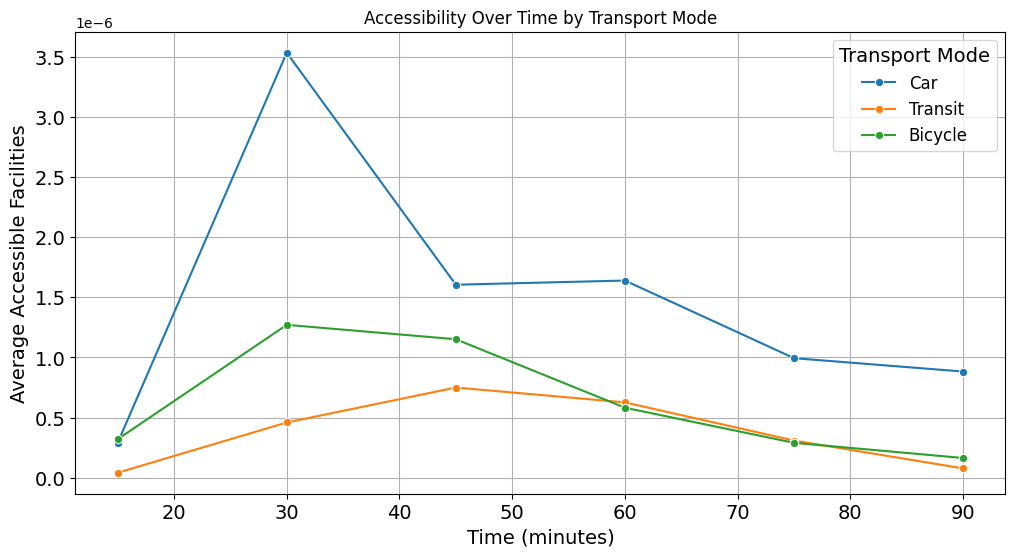

In [63]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=mode_time_accessibility_pd, x="time_min", y="avg_facilities", hue="mode", marker="o", palette="tab10")
plt.title("Accessibility Over Time by Transport Mode")
plt.xlabel("Time (minutes)", fontsize = 14)
plt.ylabel("Average Accessible Facilities", fontsize = 14)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.grid()
plt.legend(title="Transport Mode", title_fontsize = 14, fontsize = 12)
plt.savefig("accessibility_by_mode_over_time.png")
plt.show()

In [64]:
### **1️⃣ Ranking the Best Locations to Live**
# Aggregate total accessibility score per location

location_ranking = df_agg.groupBy("y", "x").agg(
    Fsum("accessibility").alias("total_accessibility"),
    avg("accessibility").alias("avg_accessibility"),
    count("domain").alias("facility_types_count")  # Number of different facility types accessible
)

In [65]:
location_ranking.show(truncate=False)

+-------+-------+---------------------+---------------------+--------------------+
|y      |x      |total_accessibility  |avg_accessibility    |facility_types_count|
+-------+-------+---------------------+---------------------+--------------------+
|2945000|3574400|7.443316369249619E-5 |6.529224885306683E-7 |114                 |
|2948400|3563400|1.1099375558407273E-4|8.879500446725818E-7 |125                 |
|2950200|3573600|1.070763270822629E-4 |8.705392445712431E-7 |123                 |
|2951000|3572200|9.521836811975279E-5 |7.678900654818773E-7 |124                 |
|2944400|3563000|7.309321686488613E-5 |6.468426271228861E-7 |113                 |
|2947600|3569200|1.2432515234065843E-4|9.867075582591939E-7 |126                 |
|2948000|3564800|1.1041566780325114E-4|8.833253424260091E-7 |125                 |
|2948200|3571200|1.0964197584208398E-4|8.701744114451109E-7 |126                 |
|2950600|3570600|1.188122095861563E-4 |9.429540443345738E-7 |126                 |
|295

In [66]:
# Convert to Pandas for geospatial processing
location_ranking_list = location_ranking.collect()

# Convert collected data to a Pandas DataFrame
location_ranking_pd = pd.DataFrame(location_ranking_list, columns=["y", "x", "total_accessibility", "avg_accessibility", "facility_types_count"])


In [67]:
### **🔹 Convert LAT/LONG to Geospatial Points**
# Create a GeoDataFrame with Point geometry
location_ranking_pd["geometry"] = location_ranking_pd.apply(
    lambda row: Point(row["x"], row["y"]), axis=1
)
gdf = gpd.GeoDataFrame(location_ranking_pd, geometry="geometry", crs="EPSG:3035")  # WGS 84


In [68]:
# Save as GeoPackage for GIS tools (QGIS, ArcGIS)
gdf.to_file("best_locations_to_live.gpkg", driver="GPKG")
